In [1]:
import itk
import scipy
import skimage
import imageio
import matplotlib.pyplot as plt
import numpy as np
import PIL
from PIL import Image
# %pylab inline

In [2]:
img_size = (int(1280/2), int(960/2))

In [3]:
template = Image.open('/Users/farid/Documents/Workspace/python/bactrace/data/samples/4_Pos_low Inflammation.tiff')
# template = skimage.color.rgb2grey(imageio.imread('/Users/farid/Documents/Workspace/python/bactrace/data/samples/4_Pos_low Inflammation.tiff'))
template = template.resize(img_size, PIL.Image.ANTIALIAS)
template = np.array(template)

# sample_name = '6_Pos_Inflammation.tiff'
# sample_name = '3_Pos_Inflammation.tiff'
# sample_name = '5_Pos_low Inflammation.tiff'
# sample_name = '7_neg.tiff'
sample_name = '8_Pos_Inflammation_suboptimal run.tiff'
sample = Image.open('/Users/farid/Documents/Workspace/python/bactrace/data/samples/' + sample_name)
sample = sample.resize(img_size, PIL.Image.ANTIALIAS)
sample = np.array(sample)
# sample = skimage.color.rgb2grey(imageio.imread('/Users/farid/Documents/Workspace/python/bactrace/data/samples/' + sample_name))
# sample = template.resize(0.5, PIL.Image.ANTIALIAS)

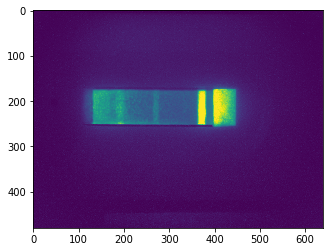

In [4]:
plt.imshow(template)

0 220


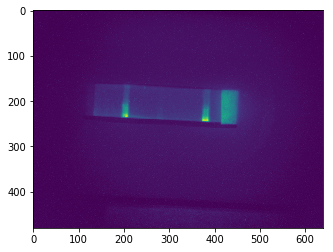

In [5]:
print(np.min(sample), np.max(sample))
plt.imshow(sample)

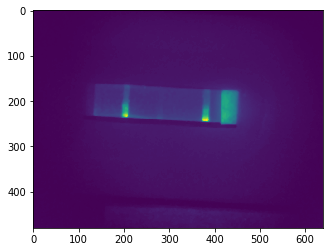

In [6]:
from scipy import ndimage
sample_med = ndimage.median_filter(sample, 5)
plt.imshow(sample_med)

In [7]:
from scipy import ndimage
def sobel_filters(img):
    Kx = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], np.float32)
    Ky = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]], np.float32)
    
    Ix = ndimage.filters.convolve(img, Kx)
    Iy = ndimage.filters.convolve(img, Ky)
    
    G = np.hypot(Ix, Iy)
    G = G / G.max() * 255
    theta = np.arctan2(Iy, Ix)
    
    return (G, theta)

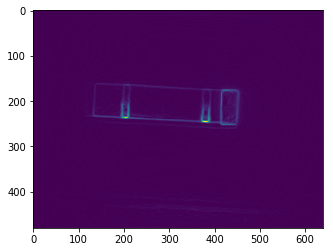

In [8]:
sample_blur = ndimage.gaussian_filter(sample_med, sigma=1)

(sample_sobel, theta) = sobel_filters(sample_blur.astype(np.float32))
plt.imshow(sample_sobel)

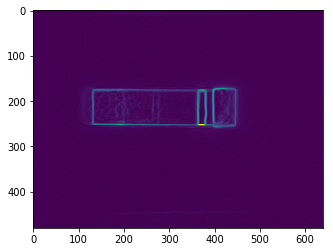

In [9]:
template_med = ndimage.median_filter(template, size=5)
template_blur = ndimage.gaussian_filter(template_med, sigma=1)

(template_sobel, theta) = sobel_filters(template_blur.astype(np.float32))
plt.imshow(template_sobel)

In [10]:
import SimpleITK as sitk

def command_iteration(method) :
    print("{0:3} = {1:7.5f} : {2}".format(method.GetOptimizerIteration(),
                                           method.GetMetricValue(),
                                           method.GetOptimizerPosition()))

In [11]:
fixed = sitk.GetImageFromArray(template_sobel)
fixed = sitk.Normalize(fixed)
fixed = sitk.DiscreteGaussian(fixed, 2.0)

In [12]:
moving = sitk.GetImageFromArray(sample_sobel)
moving = sitk.Normalize(moving)
moving = sitk.DiscreteGaussian(moving, 2.0)

In [13]:
R = sitk.ImageRegistrationMethod()

# R.SetMetricAsJointHistogramMutualInformation()
R.SetMetricAsCorrelation()

R.SetOptimizerAsGradientDescentLineSearch(learningRate=1.0,
                                          numberOfIterations=200,
                                          convergenceMinimumValue=1e-5,
                                          convergenceWindowSize=5)

In [14]:
R.SetInitialTransform(sitk.Euler2DTransform()) #fixed.GetDimension()

R.SetInterpolator(sitk.sitkLinear)

R.AddCommand( sitk.sitkIterationEvent, lambda: command_iteration(R) )

outTx = R.Execute(fixed, moving)

print("-------")
print(outTx)
print("Optimizer stop condition: {0}".format(R.GetOptimizerStopConditionDescription()))
print(" Iteration: {0}".format(R.GetOptimizerIteration()))
print(" Metric value: {0}".format(R.GetMetricValue()))

  0 = -0.08660 : (-1.2001149368114992, 0.002987796751812455, -0.0020628239848174317)
  1 = -0.03060 : (-1.6953847434848321, 0.0018229964513876722, -0.0037054677544241703)
  2 = 0.00000 : (-1.6953847434848321, 0.0018229964513876722, -0.0037054677544241703)
  3 = 0.00000 : (-1.6953847434848321, 0.0018229964513876722, -0.0037054677544241703)
-------
itk::simple::Transform
 Euler2DTransform (0x7fcc0cc281c0)
   RTTI typeinfo:   itk::Euler2DTransform<double>
   Reference Count: 2
   Modified Time: 2798
   Debug: Off
   Object Name: 
   Observers: 
     none
   Matrix: 
     0.362251 0.932081 
     -0.932081 0.362251 
   Offset: [0.0029878, -0.00206282]
   Center: [0, 0]
   Translation: [0.0029878, -0.00206282]
   Inverse: 
     0.362251 -0.932081 
     0.932081 0.362251 
   Singular: 0
   Angle       = -1.20011

Optimizer stop condition: GradientDescentLineSearchOptimizerv4Template: Convergence checker passed at iteration 4.
 Iteration: 4
 Metric value: -0.08660346992804145


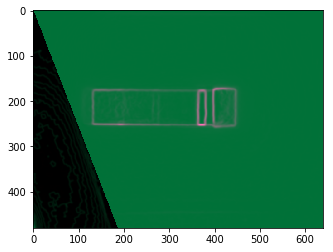

In [15]:
resampler = sitk.ResampleImageFilter()
resampler.SetReferenceImage(fixed);
resampler.SetInterpolator(sitk.sitkLinear)
resampler.SetDefaultPixelValue(1)
resampler.SetTransform(outTx)

out = resampler.Execute(moving)

simg1 = sitk.Cast(sitk.RescaleIntensity(fixed), sitk.sitkUInt8)
simg2 = sitk.Cast(sitk.RescaleIntensity(out), sitk.sitkUInt8)
sample_registered = sitk.GetArrayFromImage(simg2)
cimg = sitk.Compose(simg1, simg2, simg1//2.+simg2//2.)
# sitk.Show( cimg, "ImageRegistration2 Composition" )
plt.imshow(sitk.GetArrayFromImage(cimg))

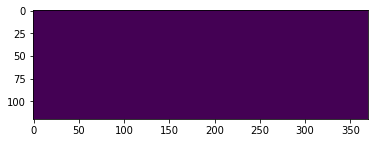

In [16]:
# cropping mask based on the template image
x1 = 270; x2 = 900; y1 = 360; y2 = 500

sample_cropped = sample_registered[y1:y2, x1:x2]
plt.imshow(sample_cropped)

In [17]:
import cv2

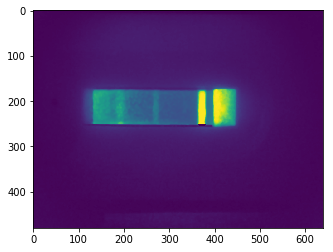

In [18]:
ret,thresh = cv2.threshold(template_sobel.astype(np.uint8),200,255,0)

contours, hierarchy = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)

img = cv2.drawContours(template_med, contours, -1, (0,255,0), 3)
plt.imshow(img)

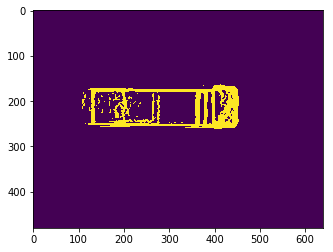

In [19]:
edge_threshold = 10
ret,thresh = cv2.threshold(template_sobel.astype(np.uint8),edge_threshold,255,0)
plt.imshow(thresh)

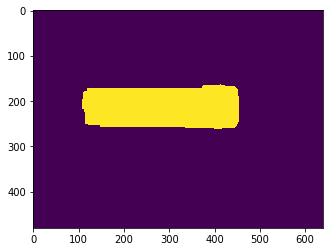

In [20]:
morph_box_size = [50, 100]
template_closed = ndimage.morphology.binary_closing(thresh, np.ones(morph_box_size), iterations=2)
plt.imshow(template_closed)

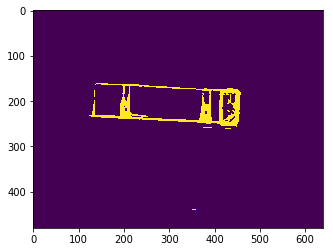

In [21]:
ret,thresh = cv2.threshold(sample_sobel.astype(np.uint8),edge_threshold,255,0)
plt.imshow(thresh)

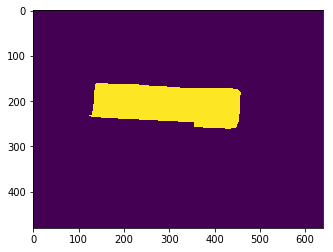

In [22]:
sample_closed = ndimage.morphology.binary_closing(thresh, np.ones(morph_box_size), iterations=2)
plt.imshow(sample_closed)

In [62]:
fixed = sitk.GetImageFromArray(template_closed.astype(np.float) * 255)
# fixed = sitk.Normalize(fixed)
fixed = sitk.DiscreteGaussian(fixed, 2.0)
tmp1 = sitk.GetArrayFromImage(fixed).astype(np.uint8)
imageio.imwrite('fixed.jpg', tmp1)

fixed = sitk.ReadImage('fixed.jpg', sitk.sitkFloat32)
# fixed = sitk.Normalize(fixed)
fixed = sitk.DiscreteGaussian(fixed, 2.0)

In [63]:
moving = sitk.GetImageFromArray(sample_closed.astype(np.float) * 255)
# moving = sitk.Normalize(moving)
moving = sitk.DiscreteGaussian(moving, 2.0)
tmp2 = sitk.GetArrayFromImage(moving).astype(np.uint8)
imageio.imwrite('moving.jpg', tmp2)

moving = sitk.ReadImage('moving.jpg', sitk.sitkFloat32)
# moving = sitk.Normalize(moving)
moving = sitk.DiscreteGaussian(moving, 2.0)

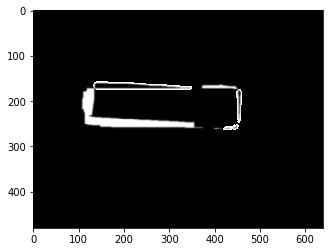

In [64]:
plt.imshow(tmp1 - tmp2, cmap='gray', vmin=0, vmax=255)

In [65]:
R = sitk.ImageRegistrationMethod()

# R.SetMetricAsJointHistogramMutualInformation()
# R.SetMetricAsCorrelation()
# R.SetMetricAsMeanSquares()
R.SetMetricAsMeanSquares()

R.SetOptimizerAsGradientDescent(learningRate=0.01,
                                numberOfIterations=100,
                                convergenceMinimumValue=1e-6, 
                                convergenceWindowSize=100,
                                maximumStepSizeInPhysicalUnits = 0.001)

In [66]:
initial_transform = sitk.CenteredTransformInitializer(fixed, 
                                                      moving, 
                                                      sitk.Euler2DTransform())
R.SetInitialTransform(initial_transform)

# R.SetInitialTransform(sitk.TranslationTransform(fixed.GetDimension())) #fixed.GetDimension()
# R.SetInitialTransform(sitk.VersorTransform())

R.SetInterpolator(sitk.sitkLinear)

R.AddCommand( sitk.sitkIterationEvent, lambda: command_iteration(R) )

outTx = R.Execute(fixed, moving)

print("-------")
print(outTx)
print("Optimizer stop condition: {0}".format(R.GetOptimizerStopConditionDescription()))
print(" Iteration: {0}".format(R.GetOptimizerIteration()))
print(" Metric value: {0}".format(R.GetMetricValue()))

  0 = 943.71068 : (89.82064832426347, 13.043236394999443, -6.624160630456097)
  1 = 11112.87913 : (98.76157778706398, 13.03833117251508, -6.627636937463261)
  2 = 11309.24363 : (88.35523635685084, 13.038468389556146, -6.627681388093765)
  3 = 3928.03431 : (-30.874366526426, 12.991349829722187, -6.6365142322276744)
  4 = 5950.15797 : (-151.427894866021, 12.961908092731292, -6.671718458028126)
  5 = 8511.58081 : (-78.97622936822286, 12.975156742080465, -6.626321435228856)
  6 = 6620.70804 : (50.75047684390081, 12.955664293902156, -6.665106583984808)
  7 = 5184.73925 : (-74.07965686140015, 12.902808561710552, -6.666279668401676)
  8 = 10944.48860 : (-87.14434175582682, 12.910453743693457, -6.668277419087097)
  9 = 8830.77579 : (-152.23343254213023, 12.955968650675292, -6.754516438672879)
 10 = 11353.04098 : (-149.29655413980782, 12.957057857552002, -6.754334717866444)
 11 = 11352.90354 : (-154.0163530231758, 12.954759909465206, -6.754177128795286)
 12 = 2052.17823 : (-33.477451647354115, 

In [30]:
fixed = sitk.GetImageFromArray(template_med)
fixed = sitk.Normalize(fixed)
fixed = sitk.DiscreteGaussian(fixed, 2.0)

In [31]:
moving = sitk.GetImageFromArray(sample_med)
moving = sitk.Normalize(moving)
moving = sitk.DiscreteGaussian(moving, 2.0)

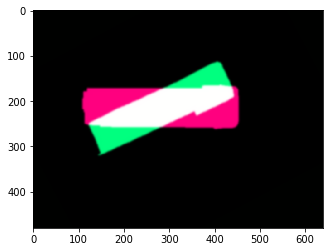

In [67]:

resampler = sitk.ResampleImageFilter()
resampler.SetReferenceImage(fixed);
resampler.SetInterpolator(sitk.sitkLinear)
resampler.SetDefaultPixelValue(1)
resampler.SetTransform(outTx)

out = resampler.Execute(moving)

simg1 = sitk.Cast(sitk.RescaleIntensity(fixed), sitk.sitkUInt8)
simg2 = sitk.Cast(sitk.RescaleIntensity(out), sitk.sitkUInt8)
sample_registered = sitk.GetArrayFromImage(simg2)
cimg = sitk.Compose(simg1, simg2, simg1//2.+simg2//2.)
# sitk.Show( cimg, "ImageRegistration2 Composition" )
plt.imshow(sitk.GetArrayFromImage(cimg))

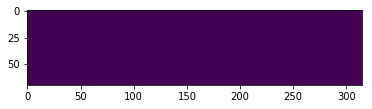

In [60]:
# cropping mask based on the template image
x1 = 270/2; x2 = 900/2; y1 = 360/2; y2 = 500/2

sample_cropped = sample_registered[int(y1):int(y2), int(x1):int(x2)]
plt.imshow(sample_cropped)

In [177]:
bin_width = 2
start_margin = 30
sample_size = sample_cropped.shape
sampling_loc = np.arange(bin_width/2 + start_margin, sample_size[1]-bin_width/2, bin_width).astype(int)

In [178]:
sample_median = np.zeros(len(sampling_loc))
for i, loc in enumerate(sampling_loc):
    sample_median[i] = np.median(sample_cropped[:,loc - int(bin_width/2) : loc + int(bin_width/2)-1])

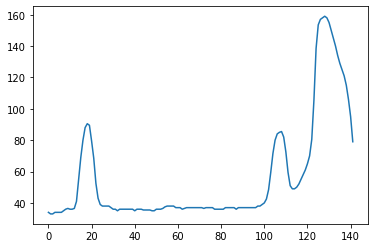

In [179]:
plt.plot(sample_median)

In [180]:
np.quantile(sample_median, np.arange(0.05, 0.95, 0.1))

array([35.   , 36.   , 36.   , 37.   , 37.   , 38.   , 42.825, 64.   ,
       85.425])

In [181]:
from scipy.signal import find_peaks
peaks_loc, properties = find_peaks(sample_median, height=np.quantile(sample_median, 0.5), width=5, distance=15)
print(properties)

{'peak_heights': array([ 90.5,  38. ,  37. ,  85.5, 159. ]), 'prominences': array([55.5,  2. ,  1. , 36.5, 80. ]), 'left_bases': array([ 2, 49, 81, 49,  2]), 'right_bases': array([ 32,  62,  87, 113, 141]), 'widths': array([ 6.80580357,  5.5       ,  5.        ,  6.75801282, 13.92424242]), 'width_heights': array([ 62.75,  37.  ,  36.5 ,  67.25, 119.  ]), 'left_ips': array([ 14.55357143,  53.5       ,  81.5       , 103.64583333,
       123.40909091]), 'right_ips': array([ 21.359375  ,  59.        ,  86.5       , 110.40384615,
       137.33333333])}


In [182]:
if len(peaks_loc) > 2:
    test_1_loc = peaks_loc[0]
    test_1_val = properties['peak_heights'][0]
if len(peaks_loc) > 3:
    test_2_loc = peaks_loc[1]
    test_2_val = properties['peak_heights'][1]
if len(peaks_loc) > 1:
    control_loc = peaks_loc[-1]
    control_val = properties['peak_heights'][-2]
else:
    sys.exit('Failed to find the locations')

if test_1_val is not None:
    print(test_1_val/control_val)
if test_2_val is not None:
    print(test_2_val/control_val)

1.0584795321637428
0.4444444444444444


In [183]:
print(peaks_loc)

[ 18  56  84 108 128]


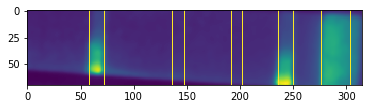

In [184]:
sample_cropped_boxes = np.copy(sample_cropped)
for loc, start, end in zip(peaks_loc, properties['left_ips'], properties['right_ips']):
    sample_cropped_boxes[:,int(start) * bin_width + start_margin] = 255
    sample_cropped_boxes[:,int(end) * bin_width + start_margin] = 255
plt.imshow(sample_cropped_boxes)

In [185]:
from tkinter import Tk, Entry, mainloop, StringVar

root = Tk()

height = 5
width = 5
for i in range(height):  # Rows
    for j in range(width):  # Columns
        text_var = StringVar()
        # here we are setting cell text value
        text_var.set('%s%s' % (i, j)) 
        b = Entry(root, textvariable=text_var)
        b.grid(row=i, column=j)
mainloop()

KeyboardInterrupt: 

In [ ]:
from tkinter import Tk, Entry, mainloop, PhotoImage, Canvas, NW   
from PIL import Image, ImageTk

In [ ]:
root = Tk()      
canvas = Canvas(root, width = 300, height = 300)      
canvas.pack()      
img = ImageTk.PhotoImage(image=Image.fromarray(np.array(sample_cropped)))     
canvas.create_image(20,20, anchor=NW, image=img)      
mainloop()

In [48]:
PixelType = itk.ctype('float')

fixedImage = itk.GetImageFromArray(template_closed.astype(np.float) * 255)
movingImage = itk.GetImageFromArray(sample_closed.astype(np.float) * 255)

Dimension = fixedImage.GetImageDimension()
FixedImageType = itk.Image[PixelType, Dimension]
MovingImageType = itk.Image[PixelType, Dimension]

TransformType = itk.TranslationTransform[itk.D, Dimension]
initialTransform = TransformType.New()

optimizer = itk.RegularStepGradientDescentOptimizerv4.New(
        LearningRate=4,
        MinimumStepLength=0.001,
        RelaxationFactor=0.5,
        NumberOfIterations=200)

metric = itk.MeanSquaresImageToImageMetricv4[
    FixedImageType, MovingImageType].New()

registration = itk.ImageRegistrationMethodv4.New(FixedImage=fixedImage,
        MovingImage=movingImage,
        Metric=metric,
        Optimizer=optimizer,
        InitialTransform=initialTransform)

movingInitialTransform = TransformType.New()
initialParameters = movingInitialTransform.GetParameters()
initialParameters[0] = 0
initialParameters[1] = 0
movingInitialTransform.SetParameters(initialParameters)
registration.SetMovingInitialTransform(movingInitialTransform)

TypeError: in method 'itkImageRegistrationMethodv4REGv4F2F2_SetFixedImage', argument 2 of type 'itkImageF2 const *'